### Imports

In [1]:
BASE_PATH = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/"

from sys import path

path.append(f"{BASE_PATH}Scripts/")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from os import makedirs
from EMDComparison import LcurveSolOEMD as lc

from datetime import datetime, timedelta
from EMDComparison.signalHelpers import compareTS, new_plot_format, plot_super_summary
import idlsave
from collections import namedtuple

### General Setup of lightcurves

In [16]:
# Set the unsafe, target safe, and dataFolder
unsafe_dir = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/"
saveFolder = f"{unsafe_dir}ISSI/"
dataFolder = f"/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/ISSI/data/"

# Parameters for DELETION, showing FIG
DELETE = False
SHOWFIG = True

# We set a large possible set of periodicities
PeriodMinMax = [5, 20]
makedirs(saveFolder, exist_ok=True)

# IN SITU DATA
df_is = pd.read_csv(f"{dataFolder}small_ch_in_situ.csv")
df_is.index = pd.to_datetime(df_is["Time"])
del df_is["Time"]

insituParams = ["Vr", "Mf", "Np", "T", "Br"]
df_is = df_is[insituParams]

# Attempt to read in dataframes
try: 
    df_171 = pd.read_csv(f'{dataFolder}small_ch_171_lc_in.csv', index_col="Time")
    df_193 = pd.read_csv(f'{dataFolder}small_ch_193_lc_in.csv', index_col="Time")
    df_flux = pd.read_csv(f'{dataFolder}ch_flux.csv', index_col="Time")
    print("Loaded csv successfully")

    for _df in (df_171, df_193, df_flux):
        _df.index = pd.to_datetime(_df.index)

except FileNotFoundError:
    # REMOTE DATA
    rs_171 = idlsave.read(f'{dataFolder}small_ch_171_lc_in.sav', verbose=False)
    rs_193 = idlsave.read(f'{dataFolder}small_ch_193_lc_in.sav', verbose=False)
    ch_flux = idlsave.read(f'{dataFolder}chflux.sav', verbose=False)

    # 171 and 193 observations
    time_array = rs_171.date_obs_171.copy()
    time_array = [t.decode() for t in list(time_array)]

    df_171 = pd.DataFrame(
        {
            'plume': rs_171.lc_171_plume_in,
            'cbpoint': rs_171.lc_171_bp_in,
            'chplume': rs_171.lc_171_ch_plume_in,
            'chole': rs_171.lc_171_ch_in,
            'qsun': rs_171.lc_171_qs_in,
        },
        index=pd.to_datetime(time_array))


    df_193 = pd.DataFrame(
        {
            'plume': rs_193.lc_193_plume_in,
            'cbpoint': rs_193.lc_193_bp_in,
            'chplume': rs_193.lc_193_ch_plume_in,
            'chole': rs_193.lc_193_ch_in,
            'qsun': rs_193.lc_193_qs_in,
        },
        index=pd.to_datetime(time_array))

    # Open and Bright point flux
    flux_time = ch_flux.hmitimes.copy()
    flux_time = [t.decode() for t in list(flux_time)]

    df_flux = pd.DataFrame(
        {
            "ch_open_flux": ch_flux.chofluxes,
            "ch_bpoint_flux": ch_flux.chbpfluxes,
        },
        index=pd.to_datetime(flux_time, format="%Y.%m.%d_%H:%M:%S_TAI"))


    df_171.to_csv(f'{dataFolder}small_ch_171_lc_in.csv', index_label="Time")
    df_193.to_csv(f'{dataFolder}small_ch_193_lc_in.csv', index_label="Time")
    df_flux.to_csv(f'{dataFolder}ch_flux.csv', index_label="Time")

Loaded csv successfully


# Using compareTS from signalFunctions

In [4]:
def AIA_compare(
                AIA=None, 
                PSP=None,
                subfolderInfo="171",
                AIA_id="171",
                PeriodMinMax=[5, 20],
                delete=True,
                showFig=True,
                highlightRegion=False,
                showSpeed=True,
                LOSPEED = 0,
                HISPEED = 0,
                windDispList = [60],
                cadSelf = 60,
                cadOther = 60
                ):
    """
    AIA = Should be AIA / HMI df
    PSP = Should be cut down is_df
    subfolderInfo tells us about both remote and IS, hopefully
    AIA_id carries information about remote observation selected
    """
    AIA.columns = [f"{AIA_id}_{i}" for i in AIA.columns]
    PSP.columns = [f"PSP_{i}" for i in PSP.columns]
    specificFolder = f"{saveFolder}{subfolderInfo}/"
    compareTS(
        dfSelf=AIA,
        dfOther=PSP,
        cadSelf=cadSelf,
        cadOther=cadOther,
        labelOther="PSP",
        winDispList=windDispList,
        corrThrPlotList=np.arange(0.65, 1, 0.05),
        PeriodMinMax=PeriodMinMax,
        showLocationList=False,
        filterPeriods=True,
        savePath=specificFolder,
        useRealTime=True,
        expectedLocationList=highlightRegion,
        detrend_box_width=200,
        delete=delete,
        showFig=showFig,
        renormalize=False,
        showSpeed=True,
        HISPEED=HISPEED,
        LOSPEED=LOSPEED,
        SPCKernelName="psp")

def AIA_newplot(
                lcDic=None, 
                dfPSP=None,
                base_folder=None,
                PeriodMinMax=[5, 20],
                showSpeed=True,
                spcSpeeds = (None, None),
                regions= None,
                ):

                new_plot_format(
                    dfInsitu=dfPSP,
                    lcDic=lcDic,
                    regions=regions,
                    base_folder=base_folder,
                    period=PeriodMinMax,
                    addResidual = False,
                    showSpeed=showSpeed,
                    addEMDLcurves = True,
                    SPCKernelName = "psp",
                    spcSpeeds=spcSpeeds,
                )

# Test case 1: 10-hours of in situ versus all remote

In [5]:
def firstCase():
    # Selecting ~ 10 hours of in situ observations with 14 switchbacks
    timeInsitu = (datetime(2018, 10, 31, 12), datetime(2018, 10, 31, 22))
    df_is_cut = df_is[timeInsitu[0]:timeInsitu[1]].copy()

    # Time in situ is one hour only?
    timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
    df_171_cut = df_171[timeSbs[0]:timeSbs[1]] 
    df_193_cut = df_193[timeSbs[0]:timeSbs[1]] 

    lcDic = {
        "171": df_171_cut.interpolate(),
        "193": df_193_cut.interpolate(),
    }

    # Selecting ~ 10 hours of in situ observations
    timeInsitu = (datetime(2018, 11, 1, 12), datetime(2018, 11, 1, 20))
    df_is_copy = df_is[timeInsitu[0]:timeInsitu[1]].copy()

    timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
    df_cut_171 = df_171[timeSbs[0]:timeSbs[1]] 
    df_cut_193 = df_193[timeSbs[0]:timeSbs[1]] 

    # This region is not actually highlighted!
    highlightRegion =  [{
                        "start": datetime(2018,10,31,16),
                        "end": datetime(2018,10,31,20),
                        "color": "blue",
                        "label": "SB bmap.",
                        }, ]

    for remDF, remLabel in zip((df_cut_171, df_cut_193), ("171", "193")):
        AIA_compare(
            AIA=remDF.copy(), PSP=df_is_copy.copy(), AIA_id=remLabel, 
            PeriodMinMax = PeriodMinMax, delete=DELETE, showFig=SHOWFIG,
            subfolderInfo="SB_OtherSBs", showSpeed=True, 
            highlightRegion = highlightRegion,
            LOSPEED=df_is_copy["Vr"].min(), HISPEED = df_is_copy["Vr"].max()
            )

## Second case with less switchbacks

In [6]:
def secondCase():

    # Selecting ~ 10 hours of in situ observations with 14 switchbacks
    timeInsitu = (datetime(2018, 11, 1, 12), datetime(2018, 11, 2, 0))  
    df_is_cut = df_is[timeInsitu[0]:timeInsitu[1]].copy()

    # Time in situ is one hour only?
    timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))  
    df_171_cut = df_171[timeSbs[0]:timeSbs[1]] 
    df_193_cut = df_193[timeSbs[0]:timeSbs[1]] 

    lcDic = {
        "171": df_171_cut.interpolate(),
        "193": df_193_cut.interpolate(),
    }

    regions = ["chole", "cbpoint", "plume", "qsun", "chplume"]
    pspLO, pspHI = df_is_cut["Vr"].min(), df_is_cut["Vr"].max()

    for dirExtension in ["SB_OtherSBs"]:
        # Dictionary with relevant RS data
        AIA_newplot(
            lcDic= lcDic,
            dfPSP= df_is_cut,
            base_folder= f"{saveFolder}{dirExtension}/",
            spcSpeeds= (pspLO, pspHI))

In [7]:
def superSum():

    regions = ["chole", "cbpoint", "plume", "qsun", "chplume"]
    pspLO, pspHI = df_is_cut["Vr"].min(), df_is_cut["Vr"].max()

    for dirExtension in ["SB_6789"]:
        # Dictionary with relevant RS data
        AIA_newplot(
            lcDic= lcDic,
            dfPSP= df_is_cut,
            base_folder= f"{saveFolder}{dirExtension}/",
            spcSpeeds= (pspLO, pspHI))

        new_plot_format(
                        dfInsitu=df_is_cut,
                        lcDic=lcDic,
                        regions=regions,
                        base_folder=f"{saveFolder}{dirExtension}/",
                        period=PeriodMinMax,
                        addResidual = False,
                        addEMDLcurves = True,
                        SPCKernelName = "psp",
                        spcSpeeds=(pspLO, pspHI),)

# Finally, do the photospheric magnetic field case

In [8]:
with open(f"/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/Scripts/ISSI/data/HMIcases.pickle", "rb") as f:
    import pickle
    cases = pickle.load(f)

HMItimesList, ISTimesList, caseNamesList, refLocations = lcv.extractDiscreteExamples(
    Caselist=cases, 
    margin=cases[0]["MARGINHOURSSOLO"], 
    AIAduration=4
    )

FileNotFoundError: [Errno 2] No such file or directory: '/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/HMI/HMI/HMI_28_T00/open_open/PSP_Vr/60s/24 - 240/IMF/Corr_matrix_all.npy'

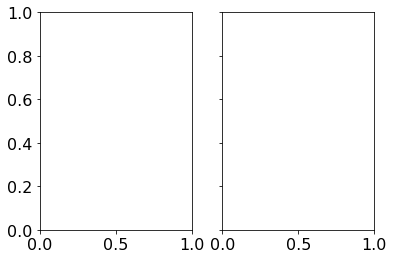

In [9]:
# TODO: Think if doing super-summary for AIA as well
# Need to compare each of regions in lcDic, df_is
# Need to use ISTimesList, HMITimesList, caseNamesList 

dfIS = (df_is[ISTimesList[0][0]: ISTimesList[0][1]]).resample(f"{12*60}s").mean()
LOSPEED, HISPEED, AVGSPEED = dfIS["Vr"].min(), dfIS["Vr"].max(), dfIS["Vr"].mean()

regLIST = ("open", "bpoint")

def compareHMI():

    for index, hmiTimes in enumerate(HMItimesList):
        _dffluxCut = df_flux[hmiTimes[0]: hmiTimes[1]]
        dirName = f"HMI/{caseNamesList[index]}"

        AIA_compare(
            AIA = _dffluxCut.copy(),
            PSP = dfIS.copy(), 
            AIA_id = "HMI",
            PeriodMinMax = (24, 240),
            delete = False,
            showFig = False,
            subfolderInfo = f"{dirName}",
            showSpeed=True,
            highlightRegion=False,
            LOSPEED = LOSPEED, 
            HISPEED = HISPEED,
            windDispList = [12* 60],
            cadSelf = 12*60,
            cadOther = 12*60
                    )

def superSummaryHMI():
    ISStendTotal = (
        dfIS.index[0].to_pydatetime(), 
        dfIS.index[-1].to_pydatetime()
        )

    allCases = []
    Casetuple = namedtuple("Case",
                            ["dirExtension", "isStend_t", "rsStend_t"])

    for index, rsTimes in enumerate(HMItimesList):
        _isT = ISTimesList[index]
        dirExtension = f"HMI/{caseNamesList[index]}"
        allCases.append(
            Casetuple(dirExtension, (_isT[0], _isT[1]),
            (rsTimes[0], rsTimes[1])))

    dfIS.columns = ["PSP_" + param for param in dfIS.columns]

    for param in dfIS.columns:
        plot_super_summary(
            allCasesList = allCases,
            longSpan = ISStendTotal,
            wvlList=regLIST,
            insituParam=param,
            period=(24, 240),
            regions=regLIST,
            unsafeEMDDataPath = "/home/diegodp/Documents/PhD/Paper_3/SolO_SDO_EUI/unsafe/ISSI/HMI/",
            SPCKernelName="psp",
            speedSuper= HISPEED,
            speedSuperLow= LOSPEED,
            speedAVG= AVGSPEED,
            showFig=True,
            figName="", 
            gridRegions=(1,2, False, True))

# compareHMI()
superSummaryHMI()
# TODO: Need to fix nrowsCols in signalHelpers

In [ ]:
# Selecting ~ 10 hours of in situ observations with 14 switchbacks
timeInsitu = (datetime(2018, 10, 31, 12), datetime(2018, 10, 31, 22))
df_is_cut = df_is[timeInsitu[0]:timeInsitu[1]].copy()

# Time in situ is one hour only?
timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
df_open = df_flux["ch_open_flux"][timeSbs[0]:timeSbs[1]] 
df_bpoint = df_flux["ch_bpoint_flux"][timeSbs[0]:timeSbs[1]] 

lcDic = {
    "open_flux": df_171_cut.interpolate(),
    "bpoint_flux": df_193_cut.interpolate(),
}

# Selecting ~ 10 hours of in situ observations
timeInsitu = (datetime(2018, 11, 1, 12), datetime(2018, 11, 1, 20))
df_is_copy = df_is[timeInsitu[0]:timeInsitu[1]].copy()

timeSbs = (datetime(2018,10,30,20), datetime(2018, 10, 30, 21))
df_cut_171 = df_171[timeSbs[0]:timeSbs[1]] 
df_cut_193 = df_193[timeSbs[0]:timeSbs[1]] 

# This region is not actually highlighted!
highlightRegion =  [{
                    "start": datetime(2018,10,31,16),
                    "end": datetime(2018,10,31,20),
                    "color": "blue",
                    "label": "SB bmap.",
                    }, ]

for remDF, remLabel in zip((df_cut_171, df_cut_193), ("171", "193")):
    AIA_compare(
        AIA=remDF.copy(), PSP=df_is_copy.copy(), AIA_id=remLabel, 
        PeriodMinMax = PeriodMinMax, delete=DELETE, showFig=SHOWFIG,
        subfolderInfo="SB_OtherSBs", showSpeed=True, 
        highlightRegion = highlightRegion,
        LOSPEED=df_is_copy["Vr"].min(), HISPEED = df_is_copy["Vr"].max()
        )

## Then produce summary plots